# <center>BankChurnersClassifier </center>
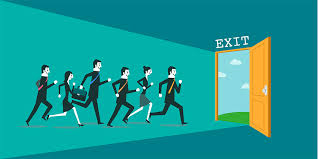

<a id="Table-Of-Contents"></a>
# Table Of Contents
* [Table Of Contents](#Table-Of-Contents)
* [Introduction](#Introduction)
* [Task Details](#Task-Details)
* [Notes](#Notes)
    - [Feature Description](#Feature-Description)
    - [Target](#Target)
* [Importing Libraries](#Importing-Libraries)
* [Read in Data (BankChurners.csv)](#Read-in-Data)
    - [Inital Glace at Training Data](#Initial-Glance-at-Training-Data)
* [Data Visualization](#Data-Visualization)
* [Data Cleansing](#Data-Cleansing)
    - [Label Encoding](#Label-Encoding)
    - [Train-Test Stratfied Split](#Train-Test-Stratfied-Split)
* [RandomForestClassifier](#RandomForestClassifier)
    - [Random Forest Confusion Matrix](#Random-Forest-Confusion-Matrix) 
    - [Random Forest Model Performance](#Random-Forest-Model-Performance)
    - [RandomSearchCV](#RandomSearchCV)
    - [Improved RandomForestClassifier](#Improved-RandomForestClassifier)
    - [Feature Importance Random Forest](#Feature-Importance-RF)
* [LightGBM Classifier ](#LightGBM-Classifier )
    - [Prepare Data for LightGBM](#Prepare-Data-for-LightGBM)
    - [Train LightGBM Model](#Train-LightGBM-Model)
    - [LightGBM Model Performance](#LightGBM-Model-Performance)
    - [Feature Importance LightGBM](#Feature-Importance-LightGBM)
* [Conclusion](#Conclusion)

<a id="Introduction"></a>
# Introduction 
This notebook goes through various machine learning techniques such as Random Forest and LightGBM. This is a beginner-level notebook but I believe you will find it still useful to read and look over. Please leave comments on where I can improve and what you liked. Thank you!

<a id="Task-Details"></a>
# Task Details
Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as Non-churning will do. So **recall** (TP/TP+FN) need to be higher.

Till now, I have managed to get a recall of 62%. Need better.

<a id="Notes"></a>
# Notes 
1. dataset is **imbalanced**
2. dataset has **no missing values** 
3. dataset has **10127** customers and **19** features
4. Seek for better **recall**, make sure you are targeting recall for Attrition_Flag = 1, many other notebooks report the wrong recall


<a id="Feature-Description"></a>
## Feature Description 

CLIENTNUM: Client number. Unique identifier for the customer holding the account

Customer_Age: Demographic variable - Customer's Age in Years

Gender: Demographic variable - M=Male, F=Female

Dependent_count: Demographic variable - Number of dependents

Education_Level: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)

Marital_Status: Demographic variable - Married, Single, Divorced, Unknown

Income_Category: Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)

Card_Category: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)

Months_on_book: Period of relationship with bank

Total_Relationship_Count: Total no. of products held by the customer

Months_Inactive_12_mon: No. of months inactive in the last 12 months

Contacts_Count_12_mon: No. of Contacts in the last 12 months

Credit_Limit: Credit Limit on the Credit Card

Total_Revolving_Bal: Total Revolving Balance on the Credit Card

Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)

Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)

Total_Trans_Amt: Total Transaction Amount (Last 12 months)

Total_Trans_Ct: Total Transaction Count (Last 12 months)

Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)

Avg_Utilization_Ratio: Average Card Utilization Ratio  

<a id="Target"></a>
## Target 

Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1(Attrited Customer) else 0(Existing Customer)

<a id="Importing-Libraries"></a>
# Importing Libraries

In [ ]:
#%% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap
import lightgbm as lgb
%matplotlib inline

from matplotlib import pyplot
from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import RandomizedSearchCV

<a id="Read-in-Data"></a>
# Read in Data (BankChurners.csv)

<a id="Initial-Glance-at-Training-Data"></a>
## Initial Glance at Training Data

In [ ]:
#%% Read raw data 
data_raw = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
# Columns to be dropped
drop_columns = ['CLIENTNUM',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

# Remove CLIENTNUM and the Naive_Bayes_Classifiers
data_raw = data_raw.drop(drop_columns,errors='ignore',axis=1)
# Initial glance at data
display(data_raw.info(verbose = True,null_counts=False))
# Check for missing or NaN data 
print("No Missing Data in this Dataset")
print(data_raw.isnull().sum())

<a id="Data-Visualization "></a>
# Data Visualization 

In [ ]:
#%% PlotMultiplePie 
# Input: df = Pandas dataframe, categorical_features = list of features , dropna = boolean variable to use NaN or not
# Output: prints multiple px.pie() 

def PlotMultiplePie(df,categorical_features = None,dropna = False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts 
    threshold = 30
    
    # if user did not set categorical_features 
    if categorical_features == None: 
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
        print(categorical_features)
    
    # loop through the list of categorical_features 
    for cat_feature in categorical_features: 
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        # prints pie chart and info if unique values below threshold 
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature, 
                 names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
            fig.show()
        else: 
            print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')

In [ ]:
#%% Use PlotMultiplePie to see the distribution of the categorical variables 
PlotMultiplePie(data_raw)

In [ ]:
#%% Print the continous features in the dataset 
continous_features = data_raw.select_dtypes(['float64']).columns.to_list()

for cont_feature in continous_features: 
    plt.figure()
    plt.title(cont_feature)
    ax = sns.distplot(data_raw[cont_feature])

In [ ]:
#%% Print the discrete features in the dataset 
discrete_features = data_raw.select_dtypes(['int64']).columns.to_list()

for disc_feature in discrete_features: 
    plt.figure()
    plt.title(disc_feature)
    ax = sns.distplot(data_raw[disc_feature],kde = False)

<a id="Data-Cleansing"></a>
# Data Cleansing

In [ ]:
#%% Clean dataset, and convert appropriate columns to appropriate dtypes()  

# convert bool and object to category 
cat_types = ['bool','object','category']
data_clean = data_raw.copy()
data_clean[data_clean.select_dtypes(cat_types).columns] = data_clean.select_dtypes(cat_types).apply(lambda x: x.astype('category'))

#     # Another method to convert bool and object to category 
# # Create a series called dtypes that has the dtype of every column in data_clean 
# dtypes = data_clean.dtypes
# # Convert object dtypes to category dtypes 
# cat_dtypes = data_clean.dtypes[dtypes == 'object'].index.tolist()
# data_clean[cat_dtypes] = data_clean[cat_dtypes].apply(lambda x: x.astype('category'))

#%% Initial glance at cleaned data
data_clean.info()

In [ ]:
#%% Split data_clean into two datasets y - depedent variable, x - independent variables 
# Map Attrited Customer = 1 and Existing Customer = 0
codes = {'Existing Customer':0, 'Attrited Customer':1}
data_clean['Attrition_Flag'] = data_clean['Attrition_Flag'].map(codes)

y = data_clean['Attrition_Flag']
X = data_clean.drop('Attrition_Flag',errors='ignore',axis=1)


## Label Encoding 

In [ ]:
#%% Label and One Hot Encoding on catagorical independent variables
    # Label Encoding for ordinal variables (ex: rankings, scales, etc)
    # One Hot Encoding for nominal variables (ex: color, gender, etc.)

# print the categories for each catagorical columns 
for col in X.select_dtypes('category').columns.to_list():
    print(col + ': '+ str(X[col].cat.categories.to_list()))

# Use One Hot Eoncoding on each catagorical independent variables 
# Because Income_Category has an "Unknown" value, unable to convert to an ordinal variable to use Label Encoding 

# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = X.select_dtypes('category').columns.to_list()
for feature in features_to_encode:
    X = encode_and_bind(X, feature)
    
X.info()

<a id="Train-Test-Stratfied-Split"></a>
## Train-Test Stratfied Split

In [ ]:
#%%  train-test stratified split using 80-20 
X_train80, X_test20, y_train80, y_test20 = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle= True,stratify = y)
# By using a stratified split, the raito of 1 and 0s are consistent btwn the two splits 
print(y_train80.value_counts())
print(y_test20.value_counts())

<a id="RandomForestClassifier"></a>
## RandomForestClassifier

In [ ]:
#%% Initial fit using RandomForestClassifier
RFC = RandomForestClassifier(random_state = 0)
RFC.fit(X_train80,y_train80)
print("Accuracy: %.2f%%" % ((RFC.score(X_test20,y_test20))*100.0))

<a id="Random-Forest-Confusion-Matrix"></a>
## Random Forest Confusion Matrix

In [ ]:
#%% Confusion Matrix for RFC
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
np.set_printoptions(precision=2)

# Plot Both Confusion Matrix, without normalization and with normalization 
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RFC, X_test20, y_test20,
                                 display_labels=RFC.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

<a id="Random-Forest-Model-Performance"></a>
## Random Forest Model Performance 

In [ ]:
#%% Calculate Precision, Recall, F1-Score, and Accurarcy 
# https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 

# predictions using RFC model given X_test20 data
y_pred20 = RFC.predict(X_test20)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# precision, recall, f1-score
precision_recall_fscore_support(y_test20, y_pred20, average='binary',pos_label=1,beta = 1)

# classification_report for Attrited Customer  
print(classification_report(y_test20,y_pred20))
print("Accuracy: %.2f%%" % (accuracy_score(y_test20, y_pred20)*100.0))
print("Recall: %.2f%%" % ((recall_score(y_test20,y_pred20))*100.0))

Although **accurarcy** is 95.66%, **recall** which is 76.00% is a more important metric. To improve this metric, we use **RandomSearchCV** to hypertune the parameters. 

<a id="RandomSearchCV"></a>
## RandomSearchCV

In [ ]:
# %% Use RandomSearchCV to tune parameters for RFC 

# Takes a while to compute and uses a lot of CPU 
# https://stats.stackexchange.com/questions/186182/a-way-to-maintain-classifiers-recall-while-improving-precision
#model
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

print('Running RandomizedSearchCV')
# default RFClassifier but set random_state = 0 to keep consistent results
MOD = RandomForestClassifier(random_state=0) 
#Implement RandomSearchCV
# Number of trees in random forest [100,150,...,500]
n_estimators = [int(x) for x in np.arange(start = 100, stop = 501, step = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(start = 20, stop = 101, step = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
scoreFunction = {"recall": "recall"}
# run a RandomizedSearchCV with 3 folds and 25 iterations 
random_search = RandomizedSearchCV(MOD,
                                   param_distributions = random_grid,
                                   n_iter = 25,
                                   scoring = scoreFunction,               
                                   refit = "recall",
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

#trains and optimizes the model
random_search.fit(X_train80, y_train80)

print('Finished RandomizedSearchCV ')

In [ ]:
#%% Evaluate method to test model performance
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    print(classification_report(test_labels,predictions))
    print("Accuracy: %.2f%%" % (accuracy_score(test_labels, predictions)*100.0))
    print("Recall: %.2f%%" % ((recall_score(test_labels,predictions))*100.0))

<a id="Improved-RandomForestClassifier"></a>
## Improved RandomForestClassifier

In [ ]:
#%% Evaluate the base model RFC vs. improved model RFC_search from RandomizedSearchCV

print("Improved Model from RandomizedSearchCV")
RFC_search = random_search.best_estimator_
RFC_search.set_params(random_state=0)
pprint(RFC_search.get_params())
evaluate(RFC_search,X_test20,y_test20)

In [ ]:
#%% Confusion Matrix for RFC_search Improved Model 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
np.set_printoptions(precision=2)

# Plot Both Confusion Matrix, without normalization and with normalization 
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(RFC_search, X_test20, y_test20,
                                 display_labels=RFC.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Both Accurarcy and Recall has improved with **Accuracy: 96.10%** and **Recall: 78.15%**. Although this is only a slight improvement we can try other machine learning algorithims to obtain a better Recall while also preserving accuracy.

<a id="Feature-Importance-RF"></a>
## Feature Importance Random Forest

In [ ]:
#%% Feature Importance 
# https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

feat_importances = pd.Series(RFC_search.feature_importances_, index=X_train80.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

In [ ]:
##% Feature Importance using shap package 
# Note: Takes several minutes to run 

# shap_values = shap.TreeExplainer(RFC_search).shap_values(X_train80)
# shap.summary_plot(shap_values, X_train80, plot_type="bar")

<a id="Feature-Importance-RF"></a>
# LightGBM Classifier 
Random Forest is a great Machine Learning algorithim, but I wanted to try a different one called LightGBM that has become popular in the recent years and won many Kaggle competitions. 

<a id="Prepare-Data-for-LightGBM"></a>
## Prepare Data for LightGBM

## MultiColumnLabelEncoder

In [ ]:
#%% MultiColumnLabelEncoder
# Code snipet found on Stack Exchange 
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
# from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

#%% Recreate X and y from data_raw
y = data_raw['Attrition_Flag']
X = data_raw.drop('Attrition_Flag',errors='ignore',axis=1)

# store the catagorical features names as a list      
cat_features = X.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X_Encoded = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X)

In [ ]:
#%% Before and After Label Encoding for X
display(X)
display(X_Encoded)

In [ ]:
#%% Before and After Label Encoding for y
y_Encoded = y.replace({'Existing Customer': 0, 'Attrited Customer': 1})
display(y)
display(y_Encoded)

<a id="Train-LightGBM-Model"></a>
## Train LightGBM Model

In [ ]:
#%%  train-test stratified split using a 80-20 split
# drop enrollee_id for aug_train as it is a useless feature 
train_x, valid_x, train_y, valid_y = train_test_split(X_Encoded, y_Encoded, test_size=0.2, shuffle=True, stratify=y, random_state=0)

# Create the LightGBM data containers
# Make sure that cat_features are used
train_data=lgb.Dataset(train_x,label=train_y, categorical_feature = cat_features)
valid_data=lgb.Dataset(valid_x,label=valid_y, categorical_feature = cat_features)

#Select Hyper-Parameters
params = {'objective':'binary',
          'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 13,
          'max_depth' : -1,
          'n_estimators' : 200,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : -1,
          'num_threads' : 4
}

In [ ]:
#%% Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 30,
                 verbose_eval= 10
                 )

<a id="LightGBM-Model-Performance"></a>
## LightGBM Model Performance

In [ ]:
#%% Overall AUC
y_hat = lgbm.predict(X_Encoded)
score = roc_auc_score(y_Encoded, y_hat)
print("Overall AUC: {:.3f}" .format(score))

In [ ]:
#%% ROC Curve for training/validation data
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
y_probas = lgbm.predict(valid_x) 
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(valid_y, y_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Great Function found on Kaggle for plotting a Confusion Matrix
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix_kaggle(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# binarize an array based of a threshold 
def binarizeArray(array,threshold = 0.5):
    return [0 if num < threshold else 1 for num in array]

In [ ]:
#%% Plot ROC curve and find best threshold to binarize the predictions from LGBM
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
pred_y = lgbm.predict(valid_x)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(valid_y, pred_y)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.figure(num=0, figsize=[6.4, 4.8])
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#%% Plot Confusion Matrix with best threshold
pref_y_bin = binarizeArray(pred_y,thresholds[ix])
cm = confusion_matrix(valid_y,pref_y_bin)
plot_confusion_matrix_kaggle(cm =cm, 
                      normalize    = False,
                      target_names = ['Existing Customer', 'Attrited Customer'],
                      title        = "Confusion Matrix")
print(classification_report(valid_y,pref_y_bin))
print("Accuracy: %.2f%%" % (accuracy_score(valid_y, pref_y_bin)*100.0))
print("Recall: %.2f%%" % ((recall_score(valid_y,pref_y_bin))*100.0))

<a id="Feature-Importance-LightGBM"></a>
## Feature Importance LightGBM

By using the best threshold we find a balance between accuracy and recall for Attrited Customers, we don't want to lower or increase the threshold as it might break the balance. If we lower the threshold, we increase recall, but the total accuracy is greatly hurt. On the other hand, if we increase the threshold, recall decreases which is something we don't want. 

With LightGBM we created a model that has an Accuracy: 94.52% and Recall: 96.92%. Although accuracy has decreased a slight amount, Recall has improved tremendously. We now check for feature importance and see which features influence the models the most 

In [ ]:
##% Feature Importance 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
lgb.plot_importance(lgbm,figsize=(15,10))

In [ ]:
##% Feature Importance using shap package 
lgbm.params['objective'] = 'binary'
shap_values = shap.TreeExplainer(lgbm).shap_values(X_Encoded)
shap.summary_plot(shap_values, X_Encoded)

<a id="Conclusion"></a>
## Conclusion

I wanted to update this notebook to include a table of contents, more visuals for the data, and implement LightGBM. My first try did not go well as Random Forest did not improve the model significantly. This time around by using LightGBM, we get a great model that has both high accuracy and recall. Please take your time and give a like and comment on the post. I would really appreciate it! 

- Joseph Chan 2021